In [5]:
!git clone https://github.com/umeshbp-iisc/ds-us-accidents-analysis.git
%cd ds-us-accidents-analysis

Cloning into 'ds-us-accidents-analysis'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), done.
Resolving deltas: 100% (1/1), done.
/content/ds-us-accidents-analysis/ds-us-accidents-analysis


In [ ]:
#import functions
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/US_Accidents_March23.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
chunk_size = 200000
chunks = []
for chunk in pd.read_csv('/content/drive/MyDrive/US_Accidents_March23.csv', chunksize=chunk_size):
    # Example: select only needed columns to reduce memory
    chunks.append(chunk)
data = pd.concat(chunks, ignore_index=True)
print("✅ Full dataset loaded in chunks successfully!")
print("Shape:", data.shape)

✅ Full dataset loaded in chunks successfully!
Shape: (7728394, 46)


In [ ]:
data['start_date'] = pd.to_datetime(data['Start_Time'], format = '%Y-%m-%d %H:%M:%S', errors='coerce')
data['date_start'] = data['start_date'].dt.strftime('%Y-%m-%d')
data['start_time'] = pd.to_datetime(data['start_date'], format= '%H:%M:%S').dt

Remove rows before 2020

In [ ]:
data = data[data['start_date'] >= '2020-01-01']

In [ ]:
data['date_start']

In [ ]:
#check null values
data.isnull().sum()

,0
ID,0
Source,0
Severity,0
Start_Time,0
End_Time,0
Start_Lat,0
Start_Lng,0
End_Lat,1156511
End_Lng,1156511
Distance(mi),0


**Remove Precipitation, Wind Chill, End_lat, End_lng and add '1' column**

In [ ]:
data.drop(['Precipitation(in)', 'Wind_Chill(F)','End_Lat', 'End_Lng'], axis =1, inplace=True)


In [ ]:
data['columm_new_1'] = 1

**Clean Zipcode**

In [ ]:
missing_pincode = data[data['Zipcode'].isnull()]
print(missing_pincode)

In [ ]:
data.loc[data['Zipcode'].isnull(), 'Start_Lat']


,Start_Lat
7794,37.885376
13889,37.885376
14515,37.885376
16208,37.885376
23539,37.505482
...,...
7722065,38.991890
7723723,44.239460
7724048,39.831696
7724049,39.838318


In [ ]:
data.loc[data['Zipcode'].isnull(), 'Start_Lng']

,Start_Lng
7794,-122.516586
13889,-122.516586
14515,-122.516586
16208,-122.516586
23539,-122.119301
...,...
7722065,-76.371090
7723723,-71.256087
7724048,-110.966258
7724049,-110.982576


**Clean the ZIPCODE column**

In [ ]:
zipcode_missing = data.loc[
    (data['Start_Lat']> 37.87) & (data['Start_Lat']<37.89) &
    (data['Start_Lng']>-123) & (data['Start_Lng']<-122), 'Zipcode']
zipcode_replace = zipcode_missing.value_counts().idxmax()
data['Zipcode'].fillna(zipcode_replace, inplace=True)

In [ ]:
data['Zipcode'].unique()

array(['45424', '43068-3402', '45176', ..., '97827-9687', '97022-8710',
       '94401-2213'], dtype=object)

In [ ]:
data = data[~data['Zipcode'].astype(str).str.contains('-',na=False)]
data['Zipcode'] = pd.to_numeric(data['Zipcode'], errors='coerce')

In [ ]:
data['Zipcode'].isnull().sum()

np.int64(0)

In [ ]:
data.dtypes

,0
ID,object
Source,object
Severity,int64
Start_Time,object
End_Time,object
Start_Lat,float64
Start_Lng,float64
Distance(mi),float64
Description,object
Street,object


**Clean AIRPORT column**

In [ ]:
data.loc[data['Airport_Code'].isnull(), 'Zipcode']


,Zipcode
7794,94710
13889,94710
14515,94710
16208,94710
23539,94710
...,...
7726723,94710
7726968,23669
7727336,97703
7727860,97703


In [ ]:
data.loc[data['Zipcode']== '94710', 'Airport_Code']

,Airport_Code


In [ ]:
def fill_missing_airportcode(row, data):
  if pd.isna(row['Airport_Code']):
    return data.loc[data['Zipcode'] == row['Zipcode'], 'Airport_Code'].value_counts().idxmax()
  else:
    return row['Airport_Code']
data['Airport_Code'] = data.apply(lambda row: fill_missing_airportcode(row, data), axis=1)

In [ ]:
data['Visibility(mi)']

,Visibility(mi)
512217,10.0
512218,10.0
512219,10.0
512220,7.0
512221,7.0
...,...
7235934,10.0
7235935,5.0
7235936,10.0
7246305,7.0


**Assign Num and Cat columns**

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df if c not in num_cols]
print(num_cols, cat_cols)

['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Zipcode', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)'] ['ID', 'Source', 'Start_Time', 'End_Time', 'Description', 'Street', 'City', 'County', 'State', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In [ ]:
#Pipeline

numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)
df_transformed = preprocess.fit_transform(df)

In [ ]:
#check cleaned up
np.isnan(df_transformed.toarray()).sum()

In [ ]:
# Display the first 10 rows of the transformed data by converting it to a dense array
#print(df_transformed.toarray()[:10])
df.head(10)

In [ ]:
#for i, chunk in enumerate(chunks):
  #print(f"Chunk {i}: {chunk.isnull().sum().sum()}")

In [ ]:
df['Wind_Direction'].unique()

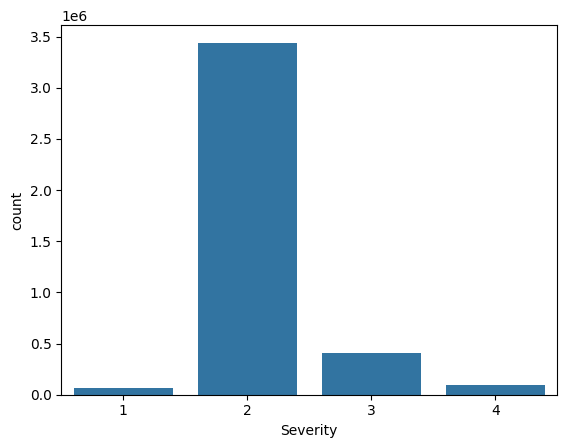

In [ ]:
#univariate analysis
sns.countplot(data=data, x='Severity')
plt.show()

Roundabout  Severity
False       2           3439107
            3            411389
            4             92382
            1             66395
True        2               114
            3                 1
            4                 1
Name: count, dtype: int64

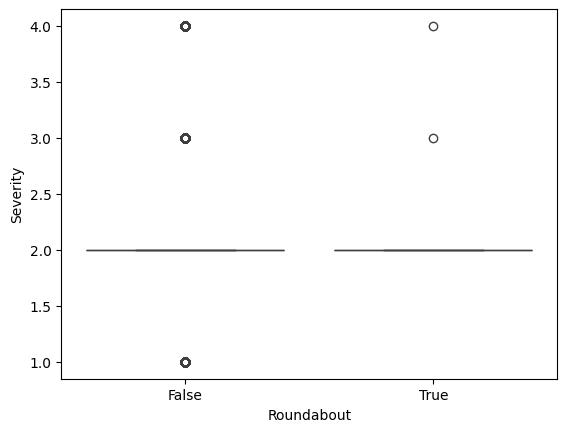

In [ ]:
sns.boxplot(x='Roundabout', y='Severity', data=data)
data.groupby('Roundabout')['Severity'].value_counts()

Sunrise_Sunset  Severity
Day             2           2230632
                3            300376
                1             54191
                4             53211
Night           2           1193688
                3            110343
                4             37495
                1             12000
Name: count, dtype: int64

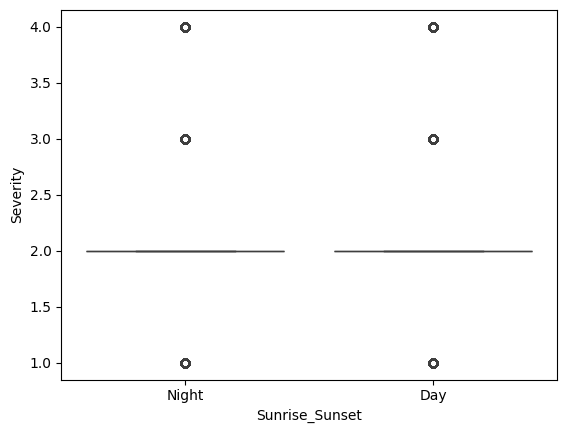

In [ ]:
sns.boxplot(x='Sunrise_Sunset', y='Severity', data=data)
data.groupby('Sunrise_Sunset')['Severity'].value_counts()

In [ ]:
data['dayofweek'] = data['start_date'].dt.dayofweek
data['day_category'] = data['dayofweek'].apply(lambda x: 'Weekend' if x in [5, 6] else 'Weekday')

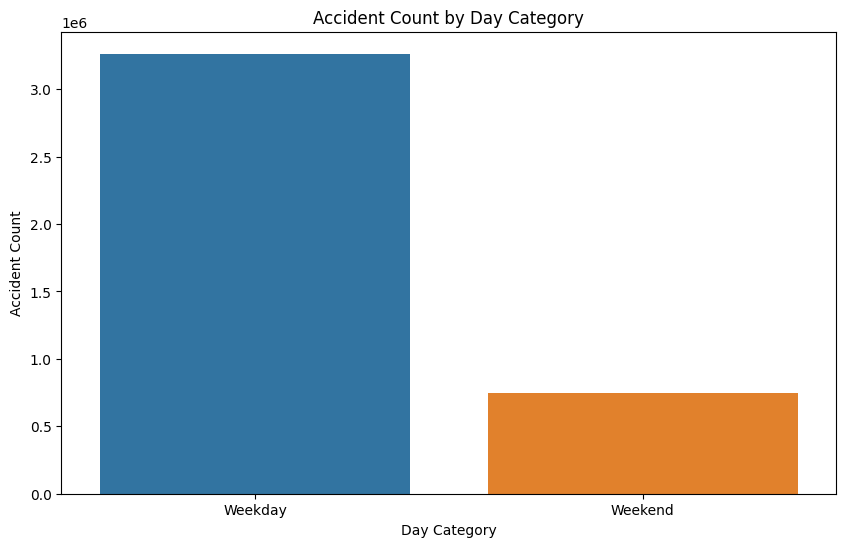

In [ ]:
groups = data.groupby('day_category')['columm_new_1'].sum().reset_index(name='accident_count')

plt.figure(figsize=(10, 6))
sns.barplot(x='day_category', y='accident_count', hue='day_category', data=groups)
plt.title('Accident Count by Day Category')
plt.xlabel('Day Category')
plt.ylabel('Accident Count')
plt.show()

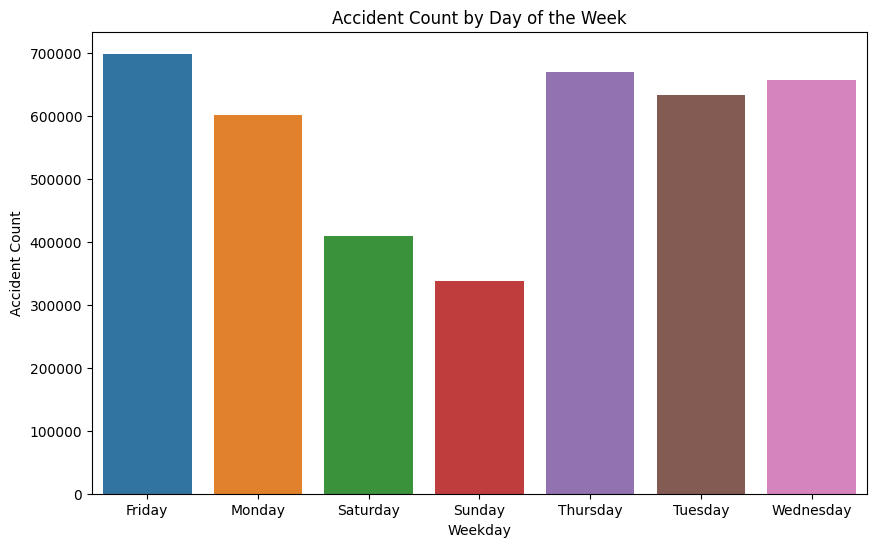

In [ ]:
data['weekday'] = data['start_date'].dt.day_name()
groups = data.groupby('weekday')['columm_new_1'].sum().reset_index(name='accident_count')

plt.figure(figsize=(10, 6))
sns.barplot(x='weekday', y='accident_count', hue='weekday', data=groups)
plt.title('Accident Count by Day of the Week')
plt.xlabel('Weekday')
plt.ylabel('Accident Count')
plt.show()

In [ ]:
data['hour'] = data['start_date'].dt.hour

In [ ]:
data['year'] = data['start_date'].dt.year

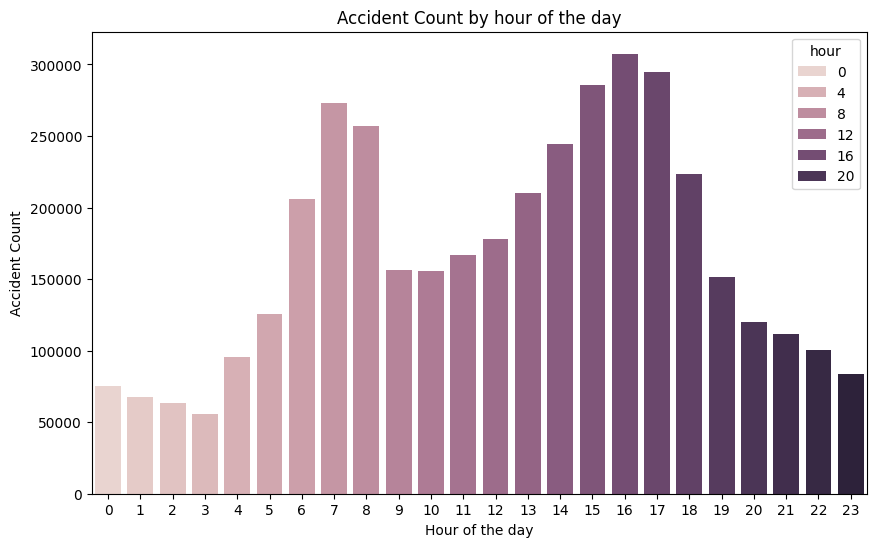

In [ ]:
groups = data.groupby('hour')['columm_new_1'].sum().reset_index(name='accident_count')

plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='accident_count', hue='hour', data=groups)
plt.title('Accident Count by hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('Accident Count')
plt.show()

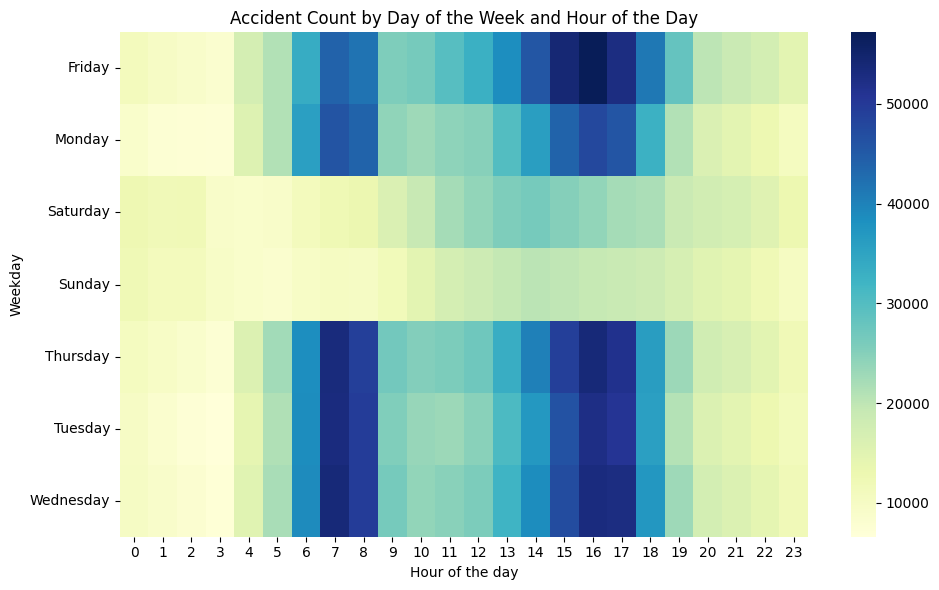

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [ ]:
groups = data.groupby(['weekday', 'hour'])['columm_new_1'].sum().reset_index(name='accident_count')
pivot = groups.pivot(index='weekday', columns='hour', values='accident_count')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=False, cmap='YlGnBu', fmt='.0f')
plt.title('Accident Count by Day of the Week and Hour of the Day')
plt.xlabel('Hour of the day')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()
plt.figure(figsize=(20, 10))

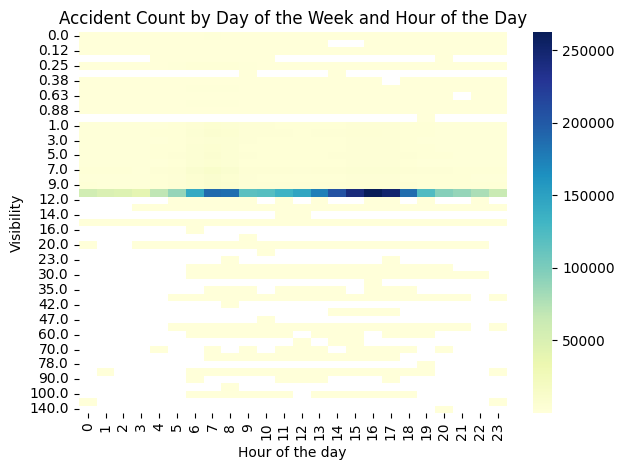

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [ ]:
groups = data.groupby(['Visibility(mi)', 'hour'])['columm_new_1'].sum().reset_index(name='accident_count')
pivot = groups.pivot(index='Visibility(mi)', columns='hour', values='accident_count')
sns.heatmap(pivot, annot=False, cmap='YlGnBu', fmt='.0f')
plt.title('Accident Count by Day of the Week and Hour of the Day')
plt.xlabel('Hour of the day')
plt.ylabel('Visibility')
plt.tight_layout()
plt.show()
plt.figure(figsize=(20, 10))

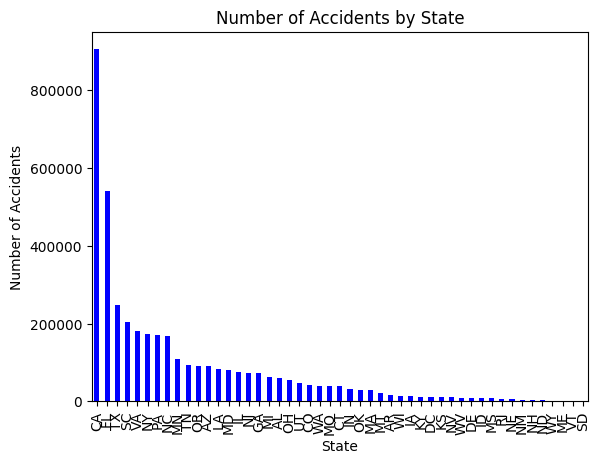

<Figure size 1600x800 with 0 Axes>

In [ ]:
state_accidents = data.groupby('State')['columm_new_1'].sum().sort_values(ascending=False)
state_accidents.plot(kind='bar', color = 'blue')
plt.title('Number of Accidents by State')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=90)
plt.figure(figsize=(16, 8))
plt.show()

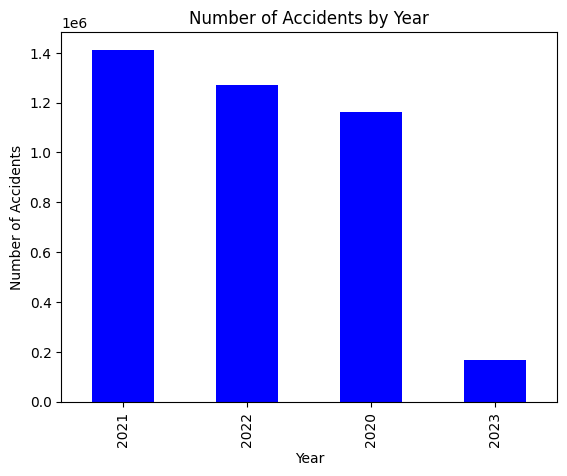

<Figure size 1600x800 with 0 Axes>

In [ ]:
yearly_acc = data.groupby('year')['columm_new_1'].sum().sort_values(ascending=False)
yearly_acc.plot(kind='bar', color = 'blue')
plt.title('Number of Accidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=90)
plt.figure(figsize=(16, 8))
plt.show()

**PUSH TO GITHUB**

In [10]:
%cd ds-us-accidents-analysis
!git pull
!git add .
#!git DS_Project_Accident_10_NOV.ipynb
!git config --global user.email "ninadphadnis@iisc.ac.in"
!git config --global user.name "NinadPhadnis"
!git commit -m "Adding intial file"
!git push origin main


mv: cannot stat '/content/DS_Project_Accident_10_NOV.ipynb': No such file or directory
[Errno 2] No such file or directory: 'ds-us-accidents-analysis'
/content/ds-us-accidents-analysis/ds-us-accidents-analysis
Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
